In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torchvision
import tarfile
from torch.autograd import Variable

import pandas as pd
import numpy as np

from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

In [2]:
path = '../fer2013.csv'

data_df = pd.read_csv(path)
data_df.head(4)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training


In [3]:
print('samples:', len(data_df))

print(data_df['Usage'].nunique())
print(data_df['Usage'].unique())

samples: 35887
3
['Training' 'PublicTest' 'PrivateTest']


In [4]:
trainData = data_df[data_df['Usage'] == 'Training']
testData = data_df[data_df['Usage'] != 'Training']
print(f'training samples:{len(trainData)}\n testing samples:{len(testData)}')

training samples:28709
 testing samples:7178


In [5]:
labels = {
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Sad',
    5:'Surprise',
    6:'Neutral'
}

In [17]:
# grab pixel values in tensor array,  
tensorData = torch.as_tensor([[float(i) for i in trainData['pixels'][j].split(' ')] for j in trainData.index])
tensorDataTest = torch.as_tensor([[float(i) for i in testData['pixels'][j].split(' ')] for j in testData.index])


In [18]:
# Simple PCA function using Torch's tensors
def PCA(indata, K=250):
    # normalize tensors
    normTensor = F.normalize(indata)

    U, S, V = torch.pca_lowrank(normTensor, q=K, center=True)

    # this is the matrix multiplication that performs the PCA
    kComps = torch.matmul(normTensor, V[:, :K])
    
    return kComps

# Preparing train
X_train = PCA(tensorData, K=500)
X_test = PCA(tensorDataTest, K=500)

In [95]:
# returns a vector for each label, i.e. [1,0,0,0,0,0,0]
def get_label_vect(df, X):
    # getting labels
    y = torch.tensor(df['emotion'].values)
    
    # transforming single column labels into a 7 element vector for each example
    zs = torch.zeros(X.shape[0], 7)#kComponents.shape[0], 7)

    for i in range(zs.shape[0]):
        for j in range(zs.shape[1]):
            if y[i] == j:
                zs[i][j] = 1
            
    return zs

y_train = get_label_vect(trainData, X_train)
y_test = torch.tensor(testData['emotion'].values)

In [40]:
# Feed Forward neural network
class ANN(nn.Module):
    def __init__(self, n_hid=8, epochs=3, eta=0.05, mB=1000):
        super(ANN, self).__init__()
        self.n_hid, self.epochs, self.eta, self.mB = n_hid, epochs, eta, mB
        
        self.optimizer = None
        self.loss_func = nn.GaussianNLLLoss()
        
        self.net2 = nn.Sequential(
            nn.Linear(X_train.shape[1], self.n_hid),
            nn.GELU(),
            
            nn.Linear(self.n_hid, self.n_hid),
            nn.Softplus(),
            
            nn.Linear(self.n_hid, 7),
        )

    def _forward(self, _X, apply_softmax=False):
        import torch.nn.functional as F
        out = self.net2(_X)
        if apply_softmax:
            out = F.softmax(out, dim=1)
        return out

    def _reset(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                 m.reset_parameters()

    def predict(self, _X):
        net_out = self._forward(_X, apply_softmax=True)
        p_values, indices = net_out.max(dim=1)
        return indices

    def fit(self, _X, _y):
        import torch.optim as optim
        self._reset()  # Reset the neural network weights
        self.optimizer = torch.optim.Adamax(self.parameters(), lr=self.eta)
        for _ in range(self.epochs):
            indices = np.arange(_X.shape[0])
            for ix in range(0, indices.shape[0]-self.mB+1, self.mB):                
                ixB = indices[ix:ix+self.mB]
                self.optimizer.zero_grad()
                net_out = self._forward(_X[ixB])
                var = net_out.var(axis=1)

                loss = self.loss_func(net_out, _y[ixB], var)
                loss.backward()
                self.optimizer.step()

In [72]:
clf = ANN(128, 1000, 0.01, 50)
clf.fit(X_train, y_train)

In [96]:
y_pred = clf.predict(X_train)
# getting labels
ytrp = torch.tensor(trainData['emotion'].values)
train_acc = (torch.sum(ytrp==y_pred).float() / X_train.shape[0])

print(f"ANN accuracy on known data= {train_acc:.3f}")

ANN accuracy on known data= 0.905


In [97]:
y_predT = clf.predict(X_test)
ytsp = torch.tensor(testData['emotion'].values)
test_acc = (torch.sum(ytsp==y_predT).float() / X_test.shape[0])

print(f"ANN accuracy on new data= {test_acc:.3f}")

ANN accuracy on new data= 0.147


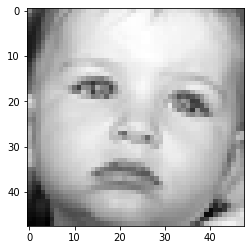

In [75]:
# showing some original sample image
plt.imshow(tensorData[1500].reshape([48, 48]), cmap='gray')

Text(0.5, 1.0, 'Neutral')

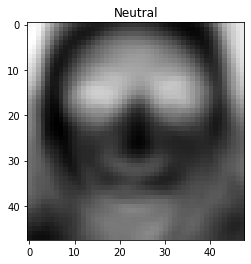

In [93]:
# Recreate approximated images using PCA
normTensor = F.normalize(tensorData)

U, S, V = torch.pca_lowrank(normTensor, q=250, center=True)
xapprox  = torch.matmul(X_train ,V.T[:250, :])

# recreation of image from xapprox (which used the k-components)
plt.imshow(torch.reshape(xapprox[1500], [48, 48]), cmap='gray')
plt.title(f'{labels[y_pred[1500].item()]}') 